<a href="https://colab.research.google.com/github/binrey/autocontour/blob/master/load_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
def add_features(x):
    import numpy as np
    import pandas as pd
    x.rename(columns={"<DATE>":"date", "<TIME>":"time", "<OPEN>":"OPN","<HIGH>":"HIG","<LOW>":"LOW","<CLOSE>":"CLS","<VOL>":"VOL"}, inplace=True)
    x.date = pd.to_datetime(x.date)
    x.time = pd.to_datetime(x.time)
    
    x["year"] = [day.year for day in x.date]
    x["month"] = [day.month for day in x.date]
    x["day"] = [day.day for day in x.date]
    x["dofw"] = [day.dayofweek for day in x.date]
    x["lab"] = 2*np.ones((x.shape[0])).astype(np.int)
    x["time"] = list(map(lambda x: x.time(), x.date))
    x["date"] = list(map(lambda x: x.date(), x.date))
    x["hour"] = [time.hour for time in x.time]
    x["minute"] = [time.minute for time in x.time]    
    
    wait_max = [0]*x.shape[0]
    wait_min = [0]*x.shape[0]
    day_min = [x.LOW[0]]*x.shape[0]
    day_max = [x.HIG[0]]*x.shape[0]
    for i in range(1, x.shape[0]):
        if x.LOW[i] < day_min[i-1]:
            day_min[i] = x.LOW[i]
            wait_min[i] = 0
        else:
            day_min[i] = day_min[i-1]
            wait_min[i] = wait_min[i-1] + 1
            
        if x.HIG[i] > day_max[i-1]:
            day_max[i] = x.HIG[i]
            wait_max[i] = 0
        else:
            day_max[i] = day_max[i-1]
            wait_max[i] = wait_max[i-1] + 1
            
        if x.day[i] != x.day[i-1]:
            wait_min[i] = 0
            wait_max[i] = 0
            day_min[i] = x.LOW[i]
            day_max[i] = x.HIG[i]
            
    x["day_min"] = day_min
    x["day_max"] = day_max 
    x["wait_min"] = wait_min
    x["wait_max"] = wait_max
    
    return x[["date", "time", "lab", "OPN", "HIG", "LOW", "CLS", "VOL", "year", "month", "day", "dofw", "hour", "minute", 
              "day_min", "day_max", "wait_min", "wait_max"]]

def calc_labs(x, h0, h1):
    import datetime
    from IPython.display import clear_output
    uniq_dates = sorted(set(x.date))
    for day in uniq_dates:
        clear_output(wait=True)
        #extended_cols = set(cols+["day", "hour"])
        curr_day = x[(x.year==day.year) & (x.month==day.month) & (x.day==day.day)]#[extended_cols]
        pp = calc_day_labs2(curr_day, h0, h1)
        #x["lab"][pp["non"]] = 0
        x["lab"][pp["pos"]] = 1
        x["lab"][pp["neg"]] = -1
        print(" -> ".join([str(uniq_dates[0])[:10], str(day)[:10], str(uniq_dates[-1])[:10]]))
    x.drop(index = x[x.lab==2].index, inplace=True)
    return x	

def calc_day_labs(x, h0, h1):
    x = x[(x.hour>h0) & (x.hour<h1)]
    work_range = list(x.index)
    t_min = x.LOW.argmin()
    t_max = x.HIG.argmax()
    if min(work_range)>min(t_min, t_max):
        if t_min<t_max:
            t_min = 0
        else:
            t_max = 0
    elif max(work_range)<max(t_min, t_max):
        if t_min>t_max:
            t_min = len(work_range)-1
        else:
            t_max = len(work_range)-1
    else:
        t_min = work_range.index(t_min)
        t_max = work_range.index(t_max)
    if t_max >= t_min:
        non_range = work_range[:t_min] 
        pos_range = work_range[t_min:t_max]
        neg_range = work_range[t_max:]
    else:
        non_range = work_range[:t_max] 
        pos_range = work_range[t_min:]
        neg_range = work_range[t_max:t_min]  
        
    ty = {"non": non_range,
          "pos": pos_range, 
          "neg": neg_range}
    return ty

def calc_day_labs2(x, h0, h1):
    x = x[(x.hour>h0) & (x.hour<h1)]
    work_range = list(x.index)
    p_cls_last = x.CLS[work_range[-1]]
    dp = p_cls_last - x.CLS[work_range]
    ty = {"pos": dp[dp>0].index, 
          "neg": dp[dp<0].index}
    return ty 
  
def plot_range(x, t0, t1, plot_width=20):
    xplot = x.iloc[range(t0, t1)]
    fig, ax1 = plt.subplots(figsize=(plot_width, 5))
    ax2 = ax1.twinx()
    f3 = xplot.day.values/xplot.day.max()
    ax1.plot(xplot["HIG"].values, "black")
    ax1.plot(xplot["LOW"].values, "black")
    ax2.plot(xplot.lab.values)
    ax2.plot(f3)
    plt.grid("on")
    return ax1, ax2

def save_files(x, folder):
    import time
    from IPython.display import clear_output
    import os
    path = os.path.join("/content/gdrive/My Drive/data/", folder)
    if not os.path.exists(path):
        os.makedirs(path)
    uniq_dates = sorted(set([str(a)[:7] for a in x.date]))
    for n_day, date in enumerate(uniq_dates):
        #clear_output(wait=True)
        cur_year = date[:4]
        cur_month = date[-2:]
        fname = str(n_day) + ".csv"
        x_month = x[(x.year==int(cur_year)) & (x.month==int(cur_month))]
        x_month.to_csv(os.path.join(path, fname), index=False)
        print(os.path.join(path, fname))
        time.sleep(1)
        #print(" -> ".join([uniq_dates[0], date, uniq_dates[-1]]))

In [3]:
from google.colab import drive
import sys
drive.mount('/content/gdrive')
sys.path.insert(0, '/content/gdrive/My Drive/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
from IPython.display import display, clear_output

warnings.filterwarnings("ignore")
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [34]:
cols_to_load = ["<DATE>","<TIME>","<OPEN>","<HIGH>","<LOW>","<CLOSE>","<VOL>"]

h0 = 0
h1 = 19
data_path = '/content/gdrive/My Drive/SBRF_5M.csv'
#data_path = './SBRF_5M.csv'
x = pd.read_csv(data_path, 
                nrows=50000, 
                usecols=cols_to_load,
                dtype={"<DATE>":str, "<TIME>":str})
x.rename(columns={"<DATE>":"date", "<TIME>":"time", "<OPEN>":"OPN","<HIGH>":"HIG","<LOW>":"LOW","<CLOSE>":"CLS","<VOL>":"VOL"}, inplace=True)
x.time = list(map(lambda x: x[:2]+":"+x[2:4]+":"+x[4:6], x.time))
x.date = x.date + " " + x.time
x.date = pd.to_datetime(x.date)

x = add_features(x)
x = calc_labs(x, h0, h1)

print(x.shape)
print(sum(x.lab==1), sum(x.lab==-1), sum(x.lab==0))
x.head()

2017-01-03 -> 2018-03-29 -> 2018-03-29
(31898, 18)
16338 15560 0


,date,time,lab,OPN,HIG,LOW,CLS,VOL,year,month,day,dofw,hour,minute,day_min,day_max,wait_min,wait_max
0,2017-01-03,10:00:00,1,17555.0,17700.0,17555.0,17692.0,7997,2017,1,3,1,10,0,17555.0,17700.0,0,0
1,2017-01-03,10:05:00,1,17698.0,17825.0,17692.0,17774.0,12150,2017,1,3,1,10,5,17555.0,17825.0,1,0
2,2017-01-03,10:10:00,1,17774.0,17845.0,17754.0,17802.0,7406,2017,1,3,1,10,10,17555.0,17845.0,2,0
3,2017-01-03,10:15:00,1,17806.0,17887.0,17805.0,17847.0,9742,2017,1,3,1,10,15,17555.0,17887.0,3,0
4,2017-01-03,10:20:00,1,17848.0,17853.0,17801.0,17829.0,2983,2017,1,3,1,10,20,17555.0,17887.0,4,1


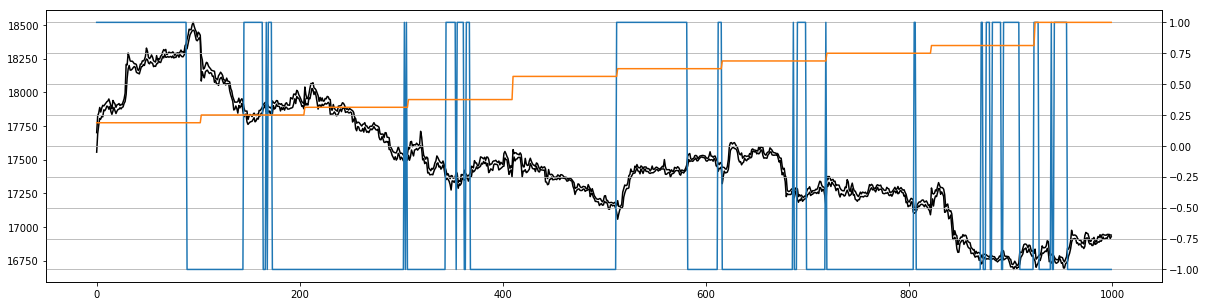

In [32]:
ax1, ax2 = plot_range(x, 0, 1000)    
#ax2.plot(x.wait_max[:1000].values/50)
#ax2.plot(x.day[:1000].values)

In [35]:
save_files(x, "SBRF")
#x = None

/content/gdrive/My Drive/data/SBRF/0.csv
/content/gdrive/My Drive/data/SBRF/1.csv
/content/gdrive/My Drive/data/SBRF/2.csv
/content/gdrive/My Drive/data/SBRF/3.csv
/content/gdrive/My Drive/data/SBRF/4.csv
/content/gdrive/My Drive/data/SBRF/5.csv
/content/gdrive/My Drive/data/SBRF/6.csv
/content/gdrive/My Drive/data/SBRF/7.csv
/content/gdrive/My Drive/data/SBRF/8.csv
/content/gdrive/My Drive/data/SBRF/9.csv
/content/gdrive/My Drive/data/SBRF/10.csv
/content/gdrive/My Drive/data/SBRF/11.csv
/content/gdrive/My Drive/data/SBRF/12.csv
/content/gdrive/My Drive/data/SBRF/13.csv
/content/gdrive/My Drive/data/SBRF/14.csv


In [0]:
from google.colab import files
files.download( "data/SBRF/8.csv" ) 

In [0]:
x_month = x[(x.year==int(2017)) & (x.month==int(7))]
x_month.to_csv("/content/gdrive/My Drive/data/test.csv", index=False)